In [11]:
import pandas as pd
import json
import os
import numpy as np
import random
from tqdm import tqdm
import collections
import re


def txt2string(fpath):
    f = open(fpath,'r')
    lines = f.readlines()
    finaldict = {}

    last_key = ""
    for line in lines:
        line = line.strip().lower()
        if line !='':
            if ':' in line:
                key, value = line.split(':', 1)
                if key != '' and not key[-1].isnumeric():
                    finaldict[key] = value.strip()
                    last_key = key
                elif last_key != "":
                    finaldict[last_key] += ' ' + line
            elif last_key != "":
                finaldict[last_key] += ' ' + line
    return finaldict


def get_label():
    sampleList = [0, 0, 0, 0, 0, 0, 0, 1, 1, 2] #: 0 train 1 validate 2 test
    x = random.choice(sampleList)
    return x

def clean_report_mimic_cxr(report):
    report_cleaner = lambda t: t.replace('\n', ' ').replace('__', '_').replace('__', '_').replace('__', '_') \
        .replace('__', '_').replace('__', '_').replace('__', '_').replace('__', '_').replace('  ', ' ') \
        .replace('  ', ' ').replace('  ', ' ').replace('  ', ' ').replace('  ', ' ').replace('  ', ' ') \
        .replace('..', '.').replace('..', '.').replace('..', '.').replace('..', '.').replace('..', '.') \
        .replace('..', '.').replace('..', '.').replace('..', '.').replace('1. ', '').replace('. 2. ', '. ') \
        .replace('. 3. ', '. ').replace('. 4. ', '. ').replace('. 5. ', '. ').replace(' 2. ', '. ') \
        .replace(' 3. ', '. ').replace(' 4. ', '. ').replace(' 5. ', '. ') \
        .strip().lower().split('. ')
    sent_cleaner = lambda t: re.sub('[.,?;*!%^&_+():-\[\]{}]', '', t.replace('"', '').replace('/', '')
                                    .replace('\\', '').replace("'", '').strip().lower())
    tokens = [sent_cleaner(sent) for sent in report_cleaner(report) if sent_cleaner(sent) != []]
    report = ' . '.join(tokens) + ' .'
    return report

# job_length = params["job_length"]
params = {}
params['length_threshold_upper'] = 800
params['length_threshold_lower'] = 0
params['findings'] = True
params['impression'] = True

# report_csv = "cxr-study-list.csv"
# image_csv = "cxr-record-list.csv"
# metadata_csv = "mimic-cxr-2.0.0-metadata.csv"

report_csv = "/media/hdd/data/imcaption/mimic/cxr-study-list.csv"
image_csv = "/media/hdd/data/imcaption/mimic/cxr-record-list.csv"
metadata_csv = "/media/hdd/data/imcaption/mimic/mimic-cxr-2.0.0-metadata.csv"
txt_report_prefix = "/media/hdd/data/imcaption/mimic/mimic-cxr-reports"
report_list = pd.read_csv(report_csv)
image_list = pd.read_csv(image_csv)
metadata_list = pd.read_csv(metadata_csv)
final_list = []
report_keys = {}
cursor_image_list = 0    
length_image_list = image_list.shape[0]
token_length_list = []

count = 0
train_num = 0
test_num = 0
val_num = 0
report_train_num = 0
report_val_num = 0
report_test_num = 0
for i in tqdm(range(report_list.shape[0])):
    path = report_list.loc[i, "path"]
    #report to string
    txt_path = os.path.join(txt_report_prefix, path)
    report_dict = txt2string(txt_path)

    #take "findings + impression" only, no finding or impression -> skip
    if "findings" not in report_dict and "impression" not in report_dict:
        # print('there is no finding or impression section', txt_path)
        continue
    else:
        text = report_dict.get("findings", '') + report_dict.get("impression",'')
        text = clean_report_mimic_cxr(text)

    #length check       
    len_text = len(text.split(' '))
    if len_text > params['length_threshold_upper']:
        continue

    tokens = [token for token in text.split(' ') if token != ""]
    if len_text < params['length_threshold_lower']:
        continue
#         pass
    token_length_list.append(len(tokens))
    study_id = report_list.loc[i, "study_id"]
    subject_id = report_list.loc[i, "subject_id"]
    #find corresponding image
    image_paths = []
    #locate all first image
    while cursor_image_list<length_image_list:
        image_sid = image_list.loc[cursor_image_list,"study_id"]
        if image_sid != study_id:
            cursor_image_list += 1
        else:                
            break
    #take all
    while cursor_image_list<length_image_list:
        image_sid = image_list.loc[cursor_image_list, "study_id"]
        if image_sid == study_id:
            image_paths.append(image_list.loc[cursor_image_list, "path"].replace('.dcm', '.jpg'))
            cursor_image_list += 1
        else:
            break
    if image_paths == []:
        continue
    label = get_label()
    if label == 0:
        report_train_num = report_train_num + 1
    elif label == 1:
        report_val_num = report_val_num + 1
    else:
        report_test_num = report_test_num + 1
    for image in image_paths:
    #form json object 
        study = {}
        study['file_path'] = image
        study['sentids'] = [count]
        study['imgid'] = count
        study['sentences'] = [{'raw':text,'imgid':count,'sentid':count,'tokens':tokens}]
        study['study_id'] = str(study_id)
        study['subject_id'] = str(subject_id)
        # shuffle split
        if label == 0:
            study['split'] = 'train'
            train_num = train_num + 1
        elif label == 1:
            study['split'] = 'val'
            val_num = val_num + 1
        else:
            study['split'] = 'test'
            test_num = test_num + 1
        final_list.append(study)  
        #asset finish
        count += 1
    #if count == job_length:
    #   break
print('total report number',
      report_train_num+report_val_num+report_test_num,
     'report_train_num', report_train_num,
     'report_val_num', report_val_num,
     'report_test_num', report_test_num)
print('total image number', train_num+test_num+val_num,
 'training image number', train_num,
  'testing image number', test_num,
   'val image num', val_num)
counter = collections.Counter
# with open('data/dataset_mimic_whole.json', 'w') as outfile:
#     json.dump({'images': final_list, 'dataset': 'mimic-cxr-test'}, outfile)

100%|██████████| 227835/227835 [00:32<00:00, 7071.82it/s]

total report number 216166 report_train_num 151069 report_val_num 43162 report_test_num 21935
total image number 360416 training image number 251893 testing image number 36508 val image num 72015


In [5]:
import re
print(text)
clean_text = clean_report_mimic_cxr(text)
print(clean_text)

the et tube terminates approximately 2.9 cm from the carina.  the ng tube courses below the diaphragm with the tip out of the field of view of the film.  there has been interval worsening of the right linear opacification likely secondary to atelectasis. no pneumothorax or definite pleural effusion is seen. the hilar and mediastinal contours are normal. there is mild cardiomegaly, stable compared to the preior exam. slight interval worsening of right lower lung atelectasis.
the et tube terminates approximately 29 cm from the carina . the ng tube courses below the diaphragm with the tip out of the field of view of the film . there has been interval worsening of the right linear opacification likely secondary to atelectasis . no pneumothorax or definite pleural effusion is seen . the hilar and mediastinal contours are normal . there is mild cardiomegaly stable compared to the preior exam . slight interval worsening of right lower lung atelectasis .


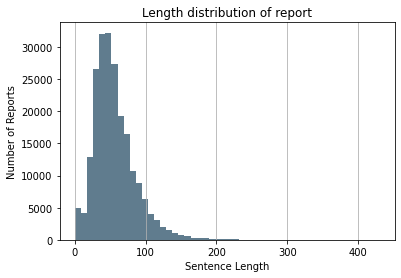

In [11]:
import matplotlib.pyplot as plt
# Generate data on commute times.
commutes = pd.Series(token_length_list)

commutes.plot.hist(grid=True, bins=50, color='#607c8e')
plt.title('Length distribution of report')
plt.xlabel('Sentence Length')
plt.ylabel('Number of Reports')
plt.grid(axis='y', alpha=0.75)